Before running this notebook, data has to be loaded with the notebook:
* 01-data_loading.ipynb

Kernel used for running: **Python 3.8**

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
import pickle

import matplotlib.colors
import matplotlib.patches as patches
import matplotlib.cm as cm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from ipynb.fs.full.Utility_functions import (draw_pitch, create_heatmap, draw_pass_map,
                                             get_openplay_xg_assisted, get_minutes_played,
                                             get_total_minutes, calculate_ppda,
                                             compute_def_actions, FreeCompetitions)

In [2]:
import sys
sys.path.insert(0, '../')

import config

### Load data

In [3]:
df_messi = pd.read_csv('../data/df_messi.csv', index_col=0, low_memory=False)

with open('../data/match_ids_no_stats.pkl', 'rb') as f:
    match_id_no_stats = pickle.load(f)
    
messi_name = config.player_name
derby_folder = config.folder_derby

In [4]:
messi_result = pd.read_csv('../data/messi_stats.csv', index_col=0)

messi_result.head()

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name,Goal_difference,barca_result
0,3773386,2020-10-31,21:00:00.000,1,1,available,available,2023-07-25T03:54:59.280826,2023-07-25T04:25:41.348202,8,11,Spain,La Liga,90,2020/2021,206,Deportivo Alavés,male,NaN,214,Spain,"[{'id': 234, 'name': 'Pablo Javier Machín Díez...",217,Barcelona,male,NaN,214,Spain,"[{'id': 676, 'name': 'Ronald Koeman', 'nicknam...",1.1.0,2,2.0,1,Regular Season,348,Estadio de Mendizorroza,214,Spain,NaN,NaN,NaN,NaN,0,Draw
1,3773565,2021-01-09,18:30:00.000,0,4,available,available,2023-07-25T03:51:37.437064,2023-07-25T04:30:16.058384,18,11,Spain,La Liga,90,2020/2021,1049,Granada,male,NaN,214,Spain,"[{'id': 1597, 'name': 'Diego Martínez Penas', ...",217,Barcelona,male,NaN,214,Spain,"[{'id': 676, 'name': 'Ronald Koeman', 'nicknam...",1.1.0,2,2.0,1,Regular Season,4667,Estadio Nuevo Los Cármenes,214,Spain,2602.0,Ricardo De Burgos Bengoetxea,214.0,Spain,-4,Win
2,3773457,2021-05-16,18:30:00.000,1,2,available,available,2022-12-02T09:26:39.496362,2023-04-27T23:03:53.506485,37,11,Spain,La Liga,90,2020/2021,217,Barcelona,male,NaN,214,Spain,"[{'id': 676, 'name': 'Ronald Koeman', 'nicknam...",209,Celta Vigo,male,NaN,214,Spain,"[{'id': 2886, 'name': 'Eduardo Germán Coudet',...",1.1.0,2,2.0,1,Regular Season,342,Spotify Camp Nou,214,Spain,NaN,NaN,NaN,NaN,-1,Loss
3,3773631,2021-02-07,21:00:00.000,2,3,available,available,2023-07-25T03:47:44.278651,2023-07-25T03:56:34.733180,22,11,Spain,La Liga,90,2020/2021,218,Real Betis,male,NaN,214,Spain,"[{'id': 733, 'name': 'Manuel Luis Pellegrini R...",217,Barcelona,male,NaN,214,Spain,"[{'id': 676, 'name': 'Ronald Koeman', 'nicknam...",1.1.0,2,2.0,1,Regular Season,352,Estadio Benito Villamarín,214,Spain,NaN,NaN,NaN,NaN,-1,Win
4,3773665,2021-03-06,21:00:00.000,0,2,available,available,2022-12-02T08:46:42.897589,2023-04-28T02:57:03.412841,26,11,Spain,La Liga,90,2020/2021,422,Osasuna,male,NaN,214,Spain,"[{'id': 1592, 'name': 'Jagoba Arrasate Eluston...",217,Barcelona,male,NaN,214,Spain,"[{'id': 676, 'name': 'Ronald Koeman', 'nicknam...",1.1.0,2,2.0,1,Regular Season,4650,Estadio El Sadar,214,Spain,2402.0,Guillermo Cuadra Fernández,214.0,Spain,-2,Win


In [6]:
free_comp = FreeCompetitions(env='github')

free_comp.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-08-17T23:51:11.837478,None,None,2023-08-17T23:51:11.837478
1,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
2,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
3,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
4,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


In [7]:
# List of match_id from the 2009/2010 season
match_id_0910 = messi_result[messi_result['season.season_id'] == 21]['match_id'].values

### Defensive analysis


In [8]:
# Calculate number of defensive actions per pitch zones

# Cutting the pitch
x_min_cut = range(0, 120, 20)
x_max_cut = range(20, 121, 20)
y_min_cut = range(0, 80, 16)
y_max_cut = range(16, 81, 16)

# Empty dataframe creation for results
def_actions_0910 = pd.DataFrame(columns=['match_id','x_min', 'x_max',
                                         'y_min', 'y_max',
                                         'def_barca', 'def_opponent'])

# Calculation of defensive actions for all matches from 2009/2010
for match_id in tqdm(match_id_0910):
    def_actions = []
    for x_min, x_max in zip(x_min_cut, x_max_cut):
        for y_min, y_max in zip(y_min_cut, y_max_cut):
            def_window = compute_def_actions(df_messi,
                                             match_id,
                                             x_min, x_max,
                                             y_min, y_max)
            opponent = [list(def_window.keys()
                             )[0] if list(def_window.keys()
                                          )[0] != 'Barcelona' else list(def_window.keys()
                                                                        )[1]][0]
            def_actions.append([match_id, x_min, x_max, y_min, y_max,
                                def_window['Barcelona'],
                                def_window[opponent]
                                ])

    temp_df = pd.DataFrame(data=def_actions,
                           columns=['match_id','x_min', 'x_max',
                                    'y_min', 'y_max',
                                    'def_barca', 'def_opponent'])

    def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)

def_actions_0910.head()

  0%|          | 0/35 [00:00<?, ?it/s]

/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated a

/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/236665702.py:37: FutureWarning: The frame.append method is deprecated a

,match_id,x_min,x_max,y_min,y_max,def_barca,def_opponent
0,69243,0,20,0,16,4,1
1,69243,0,20,16,32,3,14
2,69243,0,20,32,48,10,27
3,69243,0,20,48,64,11,22
4,69243,0,20,64,80,9,10


In [9]:
# Compute the average number of defensive actions per pitch zone
# Average value for Barca on one side and for its opponents on the other side
def_means = []
for x_min, x_max in zip(x_min_cut, x_max_cut):
    for y_min, y_max in zip(y_min_cut, y_max_cut):
        means = def_actions_0910[(def_actions_0910['x_min'] == x_min) &
                                 (def_actions_0910['x_max'] == x_max) &
                                 (def_actions_0910['y_min'] == y_min) &
                                 (def_actions_0910['y_max'] == y_max)
                                 ][['def_barca', 'def_opponent']].mean()
        
        def_means.append([x_min, x_max, y_min, y_max,
                          means['def_barca'],
                          means['def_opponent']
                          ])
    
def_actions_0910_mean = pd.DataFrame(data=def_means,
                                     columns=['x_min', 'x_max',
                                              'y_min', 'y_max',
                                              'def_barca', 'def_opponent'])

def_actions_0910_mean.head()

,x_min,x_max,y_min,y_max,def_barca,def_opponent
0,0,20,0,16,6.085714,4.800000
1,0,20,16,32,6.342857,10.028571
2,0,20,32,48,9.542857,16.942857
3,0,20,48,64,6.771429,12.285714
4,0,20,64,80,7.114286,7.028571


In [10]:
# xG p90 2009/2010 season:
xg_mean_0910 = 90 * df_messi[(df_messi['season_id'] == 21) &
                        (df_messi['player.name'] == messi_name)
                        ]['shot.statsbomb_xg'].sum() / get_total_minutes(df_messi,
                                                                         21,
                                                                         messi_name,
                                                                         'Barcelona')

xg_mean_0910

  0%|          | 0/35 [00:00<?, ?it/s]

0.6358370817119696

In [11]:
# Game with smallest xG value from Messi
# 09/10 season
#xG per90
xg_0910 = df_messi[(df_messi['match_id'].isin(match_id_0910)) &
                   (df_messi['player.name'] == messi_name)
                   ].groupby('match_id')['shot.statsbomb_xg'].sum()


xg_0910_per90 = pd.Series(data=[90 * xg_0910[x] / get_minutes_played(df_messi, 
                                                                     x, 
                                                                     messi_name,
                                                                     'Barcelona'
                                                                     ) for x in xg_0910.index],
                          index=xg_0910.index)


index_min_xg = xg_0910_per90.argmin()

match_id_min_xg = xg_0910_per90.index[index_min_xg]

match_id_min_xg

69213

In [12]:
messi_result[messi_result['match_id'] == match_id_min_xg][['home_score', 'away_score',
                                                           'home_team.home_team_name',
                                                           'away_team.away_team_name']]

,home_score,away_score,home_team.home_team_name,away_team.away_team_name
749,0,0,Espanyol,Barcelona


### Espanyol - Barcelona 2009/2010

In [13]:
# xG of Barcelona in the derby
df_messi[(df_messi['match_id'] == match_id_min_xg) &
         (df_messi['team.name'] == 'Barcelona')]['shot.statsbomb_xg'].sum()

0.152415776

In [14]:
# xG of Espanyol in the derby
df_messi[(df_messi['match_id'] == match_id_min_xg) &
         (df_messi['team.name'] == 'Espanyol') &
         (df_messi['type.name'] == 'Shot')
         ]['shot.statsbomb_xg'].sum()

0.7535398449999999

#### Defensive visualisation

/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2279149597.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mapper, shrink=0.7, label='Distance from average')


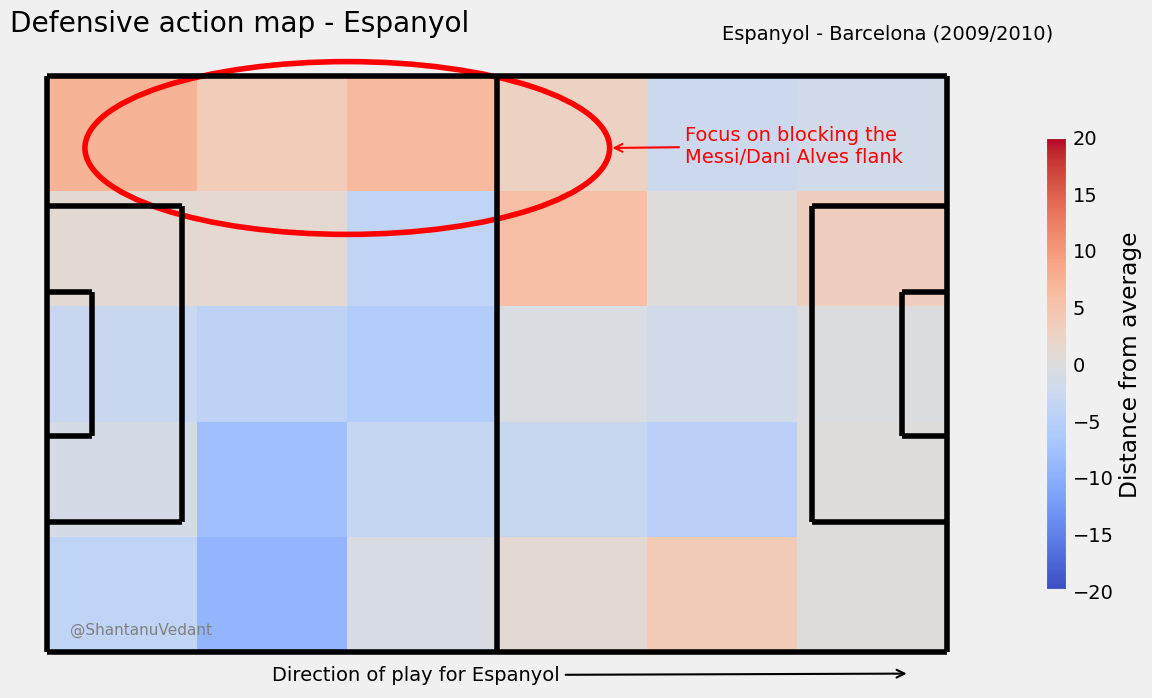

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
draw_pitch(ax)

minima = -20
maxima = 20

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap= 'coolwarm')

plt.colorbar(mapper, shrink=0.7, label='Distance from average')

# Visualization of defensive actions of Espanyol
# Number of actions compared to average numbers of Barcelona's opponents (season 2009/2010)
for index, row in def_actions_0910[def_actions_0910['match_id'] == match_id_min_xg].iterrows():
    mean_def = def_actions_0910_mean[(def_actions_0910_mean['x_min'] == row['x_min']) &
                                     (def_actions_0910_mean['x_max'] == row['x_max']) &
                                     (def_actions_0910_mean['y_min'] == row['y_min']) &
                                     (def_actions_0910_mean['y_max'] == row['y_max'])
                                     ]['def_opponent'].values[0]

    # Create a Rectangle patch
    rect = patches.Rectangle((row['x_min'], row['y_min']),
                             row['x_max'] - row['x_min'],
                             row['y_max'] - row['y_min'],
                             linewidth=1,
                             edgecolor='none',
                             facecolor=mapper.to_rgba(row['def_opponent']-mean_def),
                             )

    # Add the patch to the Axes
    ax.add_patch(rect)

    
ax.add_patch(patches.Ellipse((40, 10),
                             width=70,
                             height=24,
                             edgecolor='red',
                             fill=False,
                             linewidth=4
                             )
             )

ax.annotate("Focus on blocking the \nMessi/Dani Alves flank",
            xy=(75, 10), xytext=(85, 12),
            arrowprops=dict(arrowstyle="->", edgecolor='r', linewidth=1.5),
            color='r')

ax.set_title("Defensive action map - Espanyol",
             loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(90, -5))

ax.annotate("Direction of play for Espanyol",
            xy=(115, 83), xytext=(30, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'espanyol_defensive_map.png')

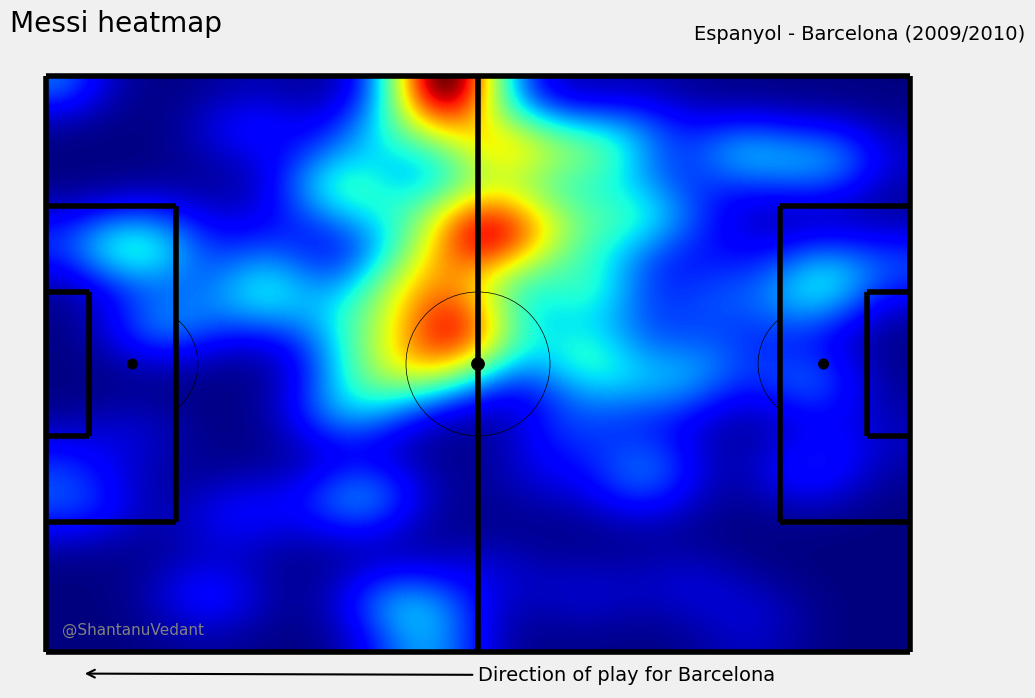

In [16]:
# Messi heatmap to compare to.
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

example_data = df_messi[(df_messi['match_id'] == match_id_min_xg) &
                        (df_messi['player.name'] == messi_name) &
                        (~df_messi['location_x'].isnull()) &
                        (~df_messi['location_y'].isnull())]

sigma = 50

img, extent = create_heatmap(120 - example_data['location_x'],
                             80 - example_data['location_y'],
                             sigma)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
ax.set_title("Messi heatmap",
             loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(90, -5))

ax.annotate("Direction of play for Barcelona",
            xy=(5, 83), xytext=(60, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'messi_heatmap.png')

#### Messi xG assisted

In [17]:
xg_assisted_p90 = pd.DataFrame(
    data=[90 * get_openplay_xg_assisted(df_messi,
                                        21,
                                        messi_name,
                                        [x]
                                        ) / get_minutes_played(df_messi,
                                                               x,
                                                               messi_name,
                                                               'Barcelona') for x in match_id_0910],
    index=match_id_0910,
    columns=['xG assisted'])

In [18]:
print(f"""xG assisted by Messi:
* Average 2009/2010: {xg_assisted_p90['xG assisted'].mean():.2f}
* Espanyol/Barcelona: {xg_assisted_p90[xg_assisted_p90.index == match_id_min_xg].values[0][0]:.2f}
""")

xG assisted by Messi:
* Average 2009/2010: 0.19
* Espanyol/Barcelona: 0.02



#### Messi pass map

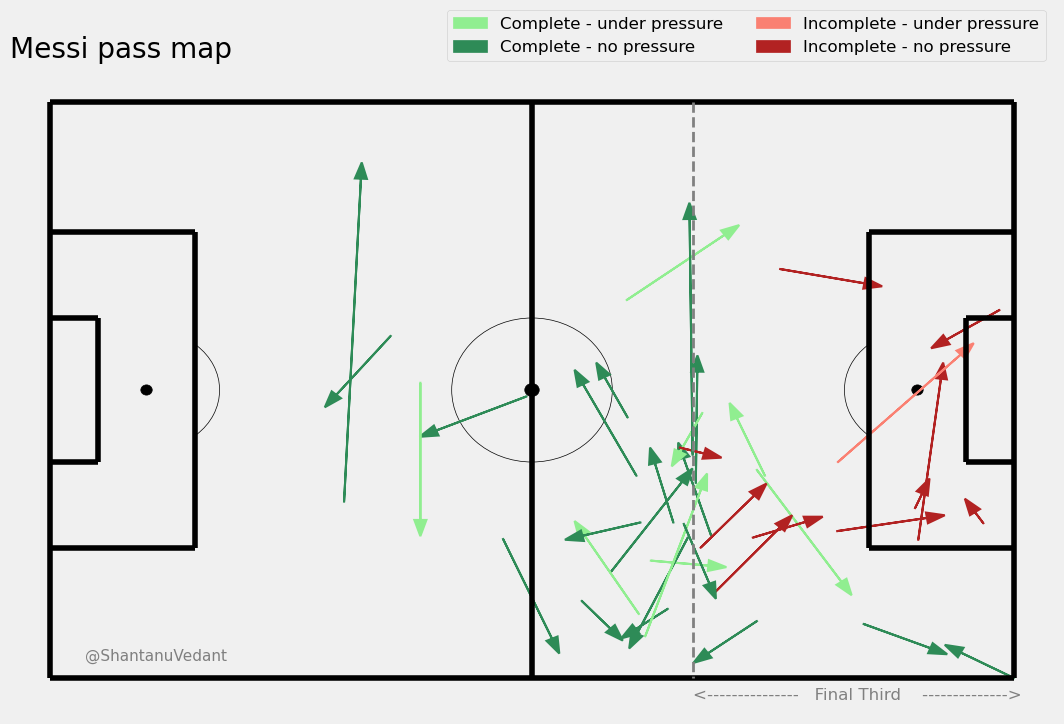

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['player.name'] == messi_name) & 
                           (df_messi['type.name'] == 'Pass')
                           ].iterrows():
    if row['pass.outcome.name'] == 'Incomplete':
        if row['under_pressure'] == True:
            color = "salmon"
        else:
            color = "firebrick"
    else:
        if row['under_pressure'] == True:
            color = 'lightgreen'
        else:
            color = 'seagreen'
            
    ax.arrow(row['location_x'],
             row['location_y'],
             row['end_location_x'] - row['location_x'],
             row['end_location_y'] - row['location_y'],
             color=color,
             linewidth=1.5,
             head_width=1.5,
             length_includes_head=True
             )
    
greenPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'lightgreen')
redPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'salmon')

greenPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'seagreen')
redPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'firebrick')

leg = ax.legend([greenPatch_up, greenPatch, redPatch_up, redPatch],
                ['Complete - under pressure', 'Complete - no pressure',
                 'Incomplete - under pressure', 'Incomplete - no pressure'],
                loc='upper right',
                bbox_to_anchor = (1, 1.1),
                fontsize=12,
                ncol=2)

plt.plot([80, 80], [0, 80],
         color='grey',
         linewidth=2,
         linestyle='--'
         )

plt.text(80, 83, "<---------------   Final Third    -------------->",
         {'color': 'grey', 'fontsize': 12})


ax.set_title("Messi pass map",
             loc='left')

fig.savefig(derby_folder + 'messi_pass_map.png')

#### Messi carry map 

In [20]:
# Percentage of carry under pressure for Messi in the derby
pressure_ratio_carry = len(
    df_messi[(df_messi['match_id'] == match_id_min_xg) &
             (df_messi['player.name'] == messi_name) & 
             (df_messi['type.name'] == 'Carry') &
             (df_messi['under_pressure'] == True)
             ]) / len(df_messi[(df_messi['match_id'] == match_id_min_xg) &
                               (df_messi['player.name'] == messi_name) & 
                               (df_messi['type.name'] == 'Carry')
                               ])

pressure_ratio_carry

0.6153846153846154

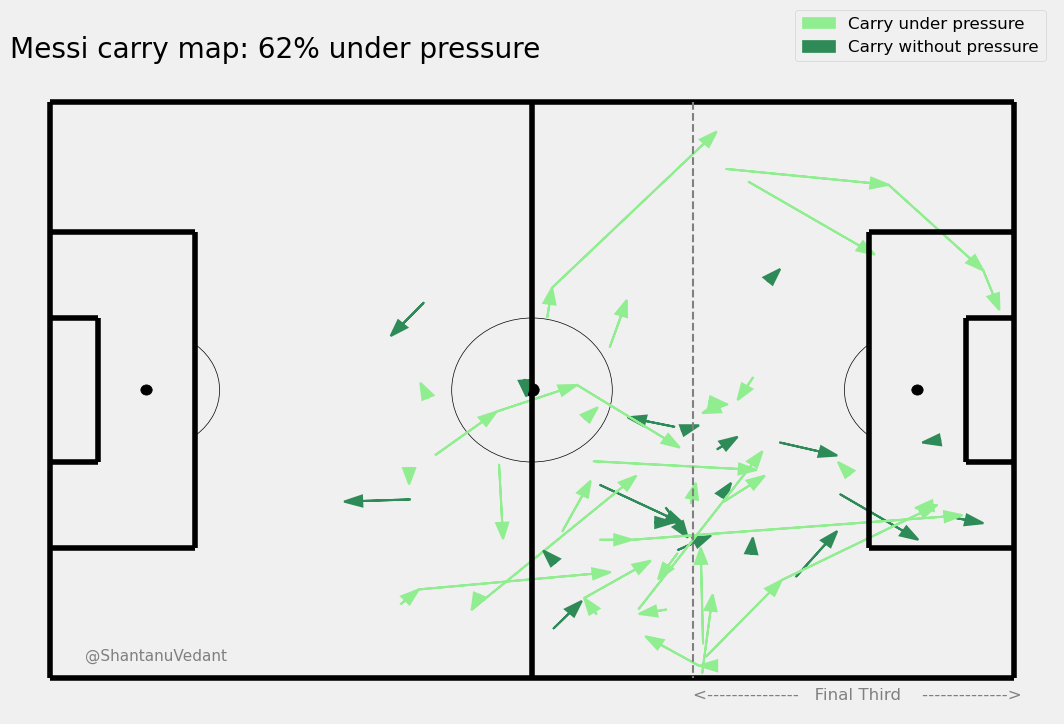

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['player.name'] == messi_name) & 
                           (df_messi['type.name'] == 'Carry')
                           ].iterrows():

    if row['under_pressure'] == True:
        color = 'lightgreen'
    else:
        color = 'seagreen'

    ax.arrow(row['location_x'],
             row['location_y'],
             row['end_location_x'] - row['location_x'],
             row['end_location_y'] - row['location_y'],
             color=color,
             linewidth=1.5,
             head_width=1.5,
             length_includes_head=True
             )
    
greenPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'lightgreen')
greenPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'seagreen')

leg = ax.legend([greenPatch_up, greenPatch],
                ['Carry under pressure', 'Carry without pressure'],
                loc='upper right',
                bbox_to_anchor = (1, 1.1),
                fontsize=12)

plt.plot([80, 80], [0, 80],
         color='grey',
         linewidth=1.5,
         linestyle='--'
         )

plt.text(80, 83, "<---------------   Final Third    -------------->",
         {'color': 'grey', 'fontsize': 12})

ax.set_title(f"Messi carry map: {100*pressure_ratio_carry:.0f}% under pressure",
            loc='left')


fig.savefig(derby_folder + 'messi_carry_map.png')

#### Passing networks

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/lineups/69213.json'

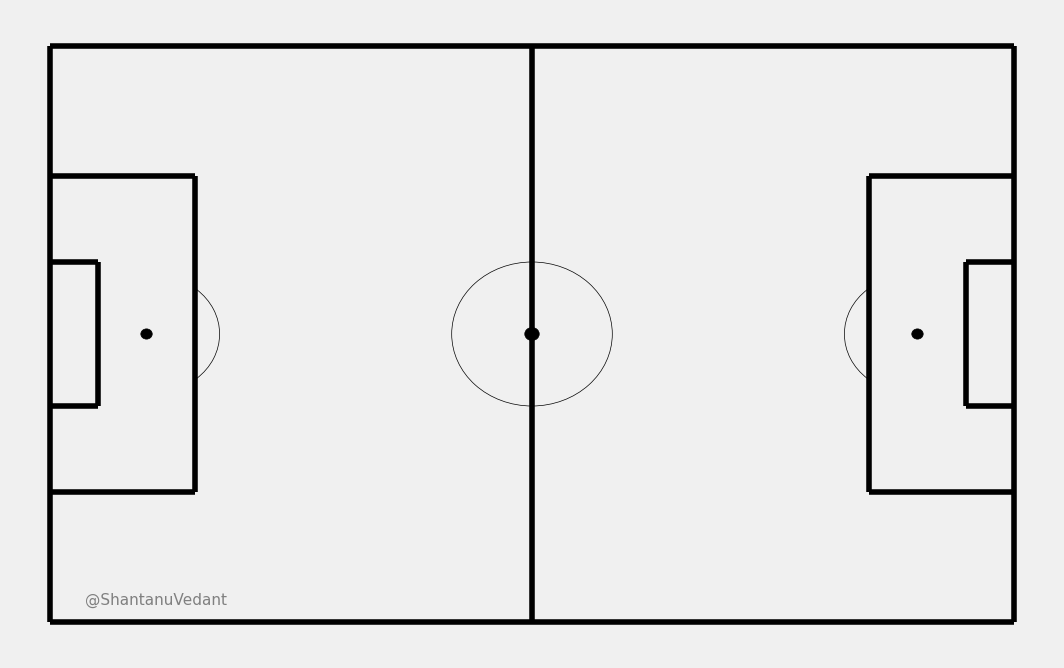

In [22]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

draw_pass_map(ax, df_messi, match_id_min_xg, 'Barcelona')

fig.savefig(derby_folder + 'pass_network_barcelona_before_redcard.png')

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/lineups/69213.json'

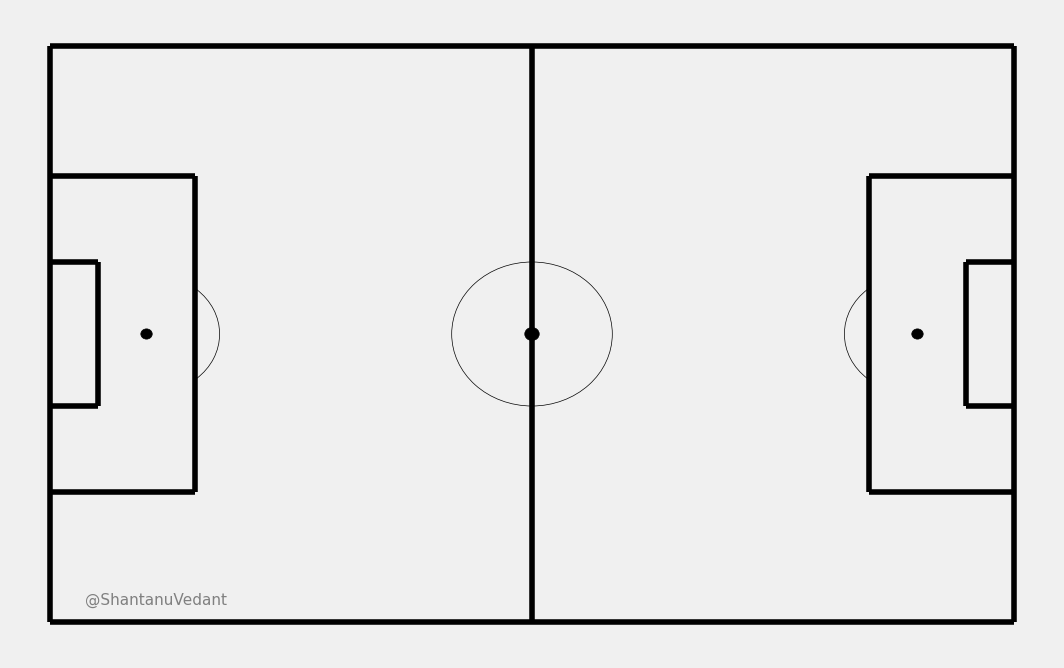

In [23]:
red_card = df_messi[(df_messi['match_id'] == match_id_min_xg) &
                    (df_messi['foul_committed.card.name'] == 'Second Yellow')
                    ]['time'].values[0]

fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

draw_pass_map(ax, df_messi, match_id_min_xg, 'Barcelona',
              min_time=red_card,
              max_time=df_messi[df_messi['match_id'] == match_id_min_xg]['time'].max()
              )

fig.savefig(derby_folder + 'pass_network_barcelona_after_redcard.png')

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/lineups/69213.json'

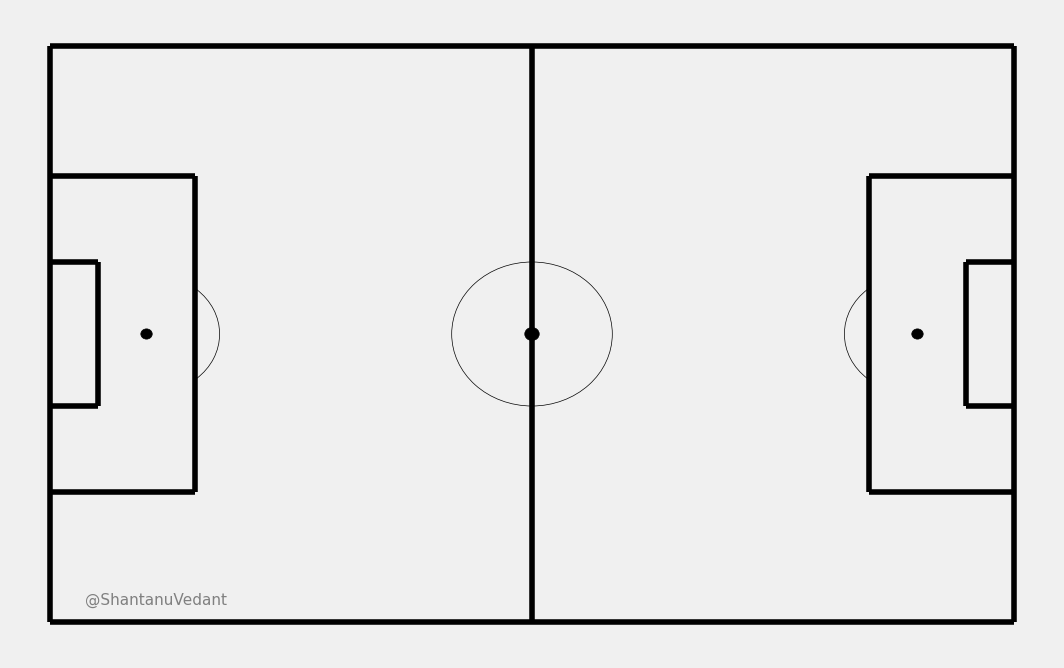

In [24]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

draw_pass_map(ax, df_messi, match_id_min_xg, 'Espanyol',max_time=58.0)

fig.savefig(derby_folder + 'pass_network_espanyol_before_redcard.png')

### Extra

Analysis that are not in the article.

#### Espanyol pressure heatmap

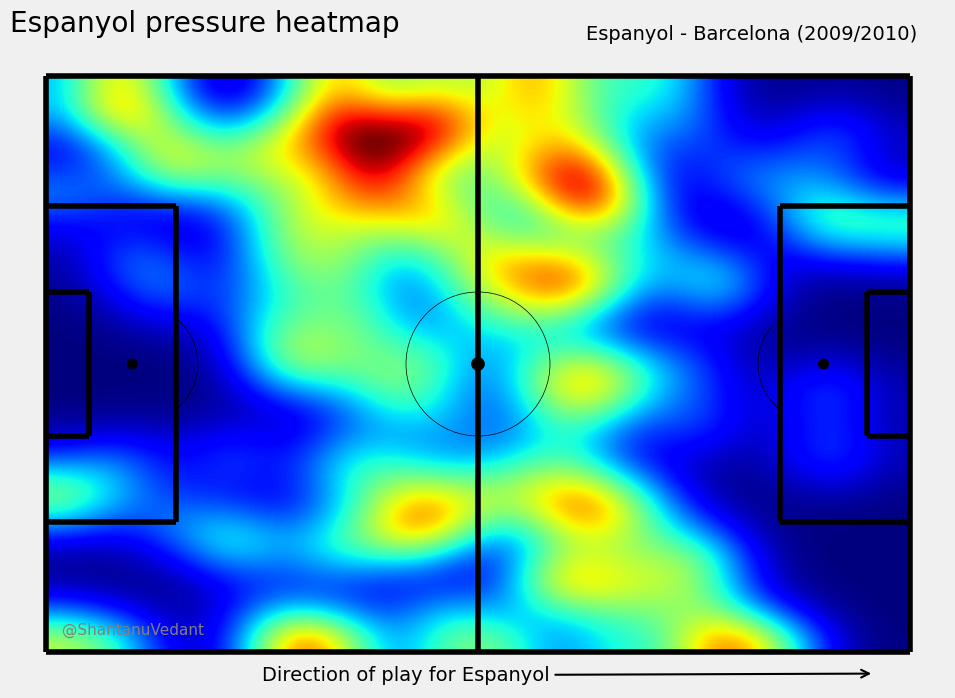

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

pressure_data = df_messi[(df_messi['match_id'] == match_id_min_xg) &
                         (df_messi['team.name'] == 'Espanyol') &
                         (df_messi['type.name'] == 'Pressure')
                         ]

sigma = 50

img, extent = create_heatmap(pressure_data['location_x'],
                             pressure_data['location_y'],
                             sigma)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)

ax.set_title("Espanyol pressure heatmap",
            loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(75, -5))

ax.annotate("Direction of play for Espanyol",
            xy=(115, 83), xytext=(30, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'espanyol_frequency_pressure_map.png')

#### Barcelona Snap-shots
Only 4 shots in the entire game, and not good ones

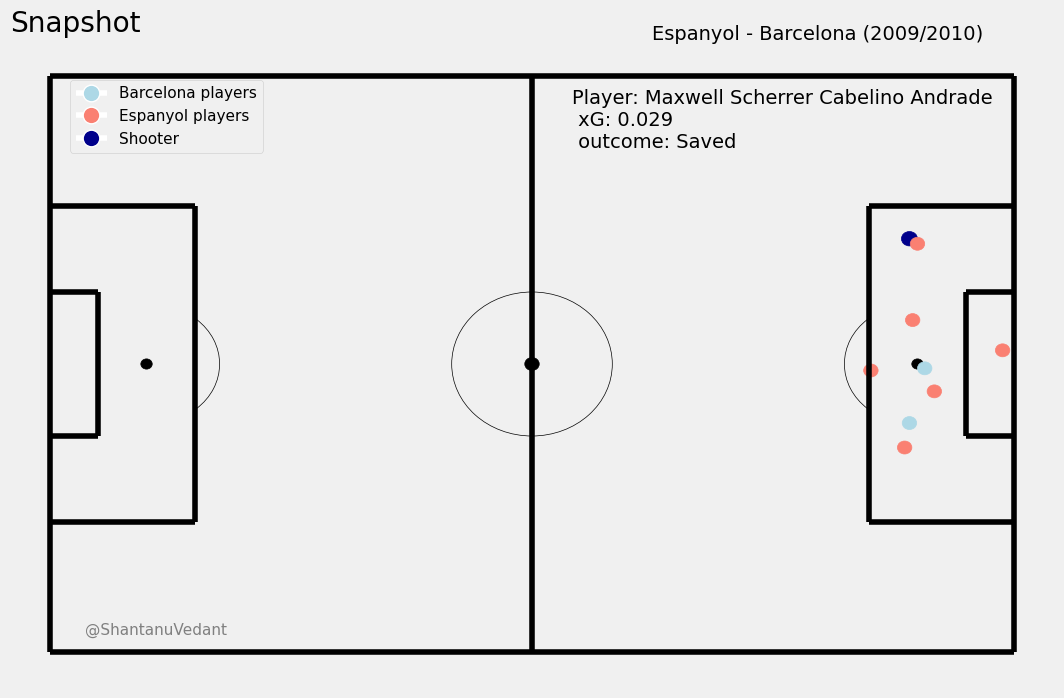

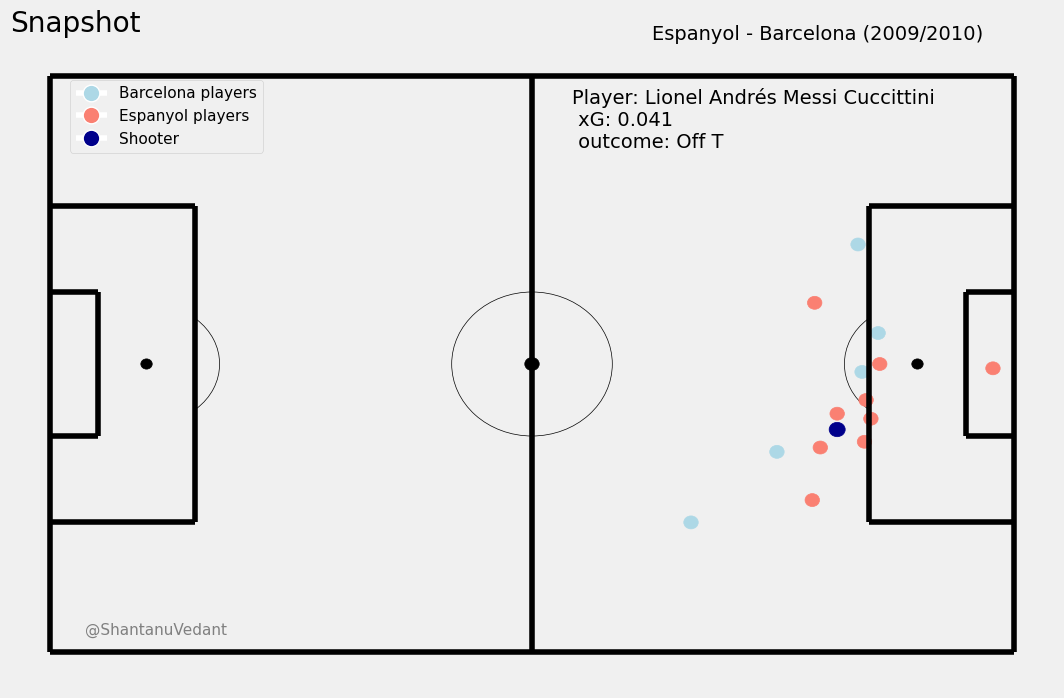

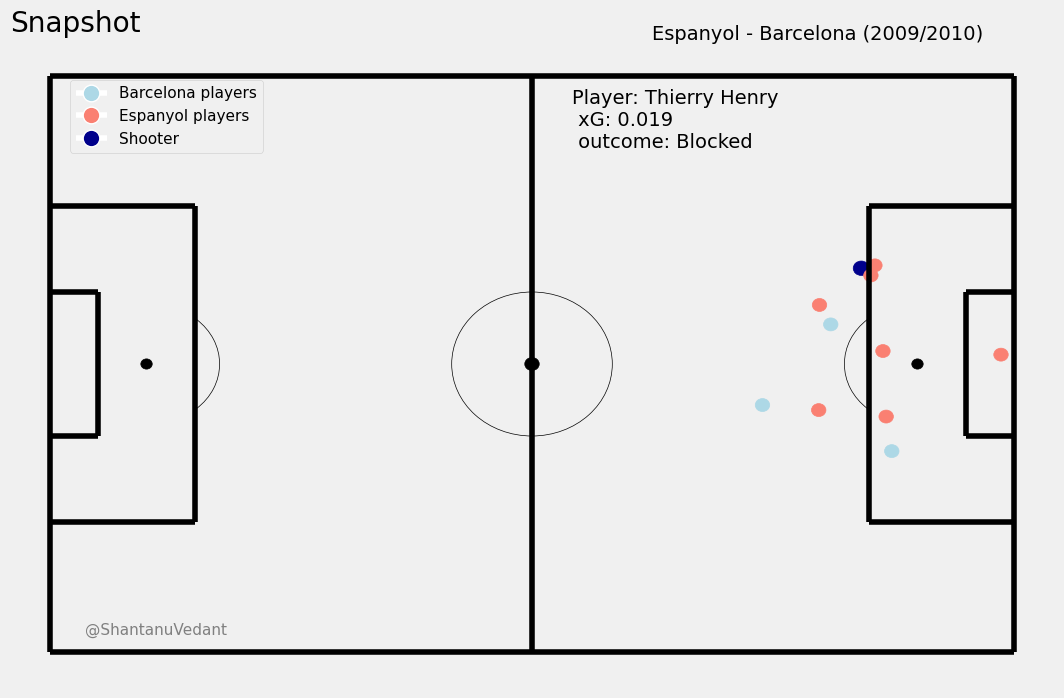

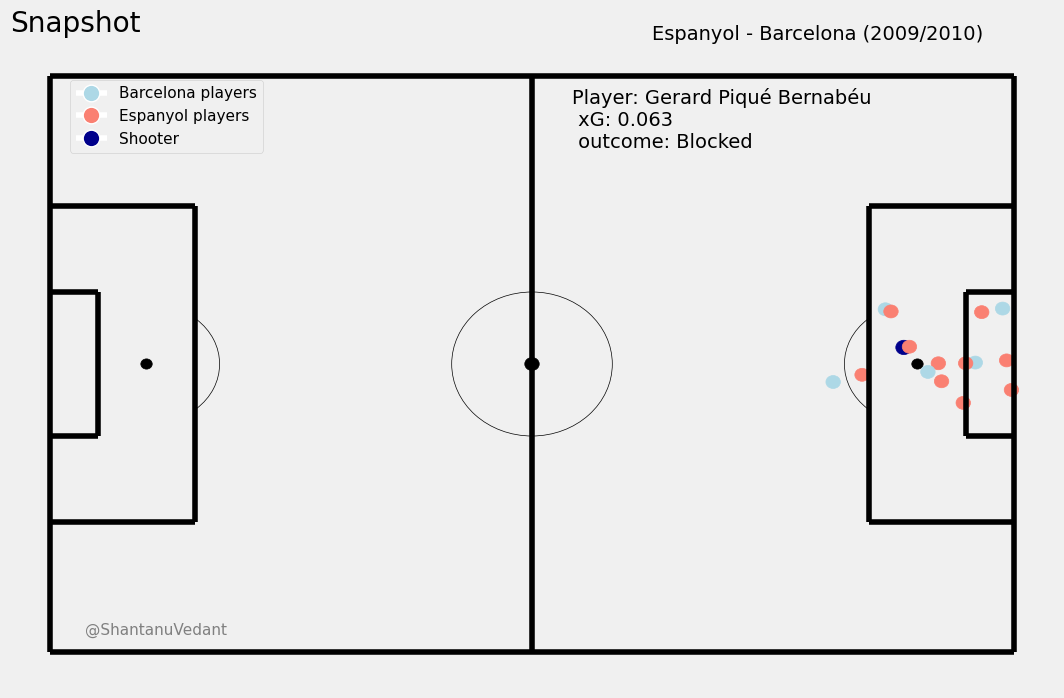

In [26]:
from ast import literal_eval
from matplotlib.lines import Line2D

line_barca = Line2D(range(1), range(1), color="white",
                    markersize=12, marker='o', markerfacecolor="lightblue")
line_espanyol = Line2D(range(1), range(1), color="white",
                       markersize=12, marker='o', markerfacecolor="salmon")
line_shooter = Line2D(range(1), range(1), color="white",
                      markersize=12, marker='o', markerfacecolor="darkblue")

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['team.name'] == 'Barcelona') &
                           (df_messi['type.name'] == 'Shot')
                           ].iterrows():
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    draw_pitch(ax)

    ax.add_patch(plt.Circle(row[['location_x', 'location_y']], 1, color="darkblue"))
    ax.annotate(f"""Player: {row['player.name']
                           } \n xG: {round(row['shot.statsbomb_xg'],3)
                                     } \n outcome: {row['shot.outcome.name']}""",
                (65,10))

    for player in literal_eval(row['shot.freeze_frame']):
        if player['teammate']:
            color_p = 'lightblue'
        else:
            color_p = 'salmon'

        ax.add_patch(plt.Circle(player['location'],
                                0.9,
                                color=color_p,
                                ))
        
    leg = ax.legend([line_barca, line_espanyol, line_shooter],
                    ['Barcelona players', 'Espanyol players', 'Shooter'],
                    loc='upper left',
                    bbox_to_anchor = (0.05, 0.95),
                    fontsize=11,
                    )
        
    ax.set_title(f"Snapshot",
                 loc='left')

    ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(75, -5))

    fig.savefig(f"{derby_folder}snapshot_{row['player.name'].split(' ')[0]}.png")

#### To Messi pass map

In [27]:
df_messi[(df_messi['match_id'] == match_id_min_xg) &
         (df_messi['type.name'] == 'Pass') &
         (df_messi['pass.recipient.name'] == messi_name)]['player.name'].value_counts(dropna=False)

Xavier Hernández Creus               11
Daniel Alves da Silva                 9
Carles Puyol i Saforcada              6
Pedro Eliezer Rodríguez Ledesma       6
Gerard Piqué Bernabéu                 5
Maxwell Scherrer Cabelino Andrade     4
Gabriel Alejandro Milito              3
Sergio Busquets i Burgos              3
Gnégnéri Yaya Touré                   3
Seydou Kéita                          3
Zlatan Ibrahimović                    3
Thierry Henry                         1
Name: player.name, dtype: int64

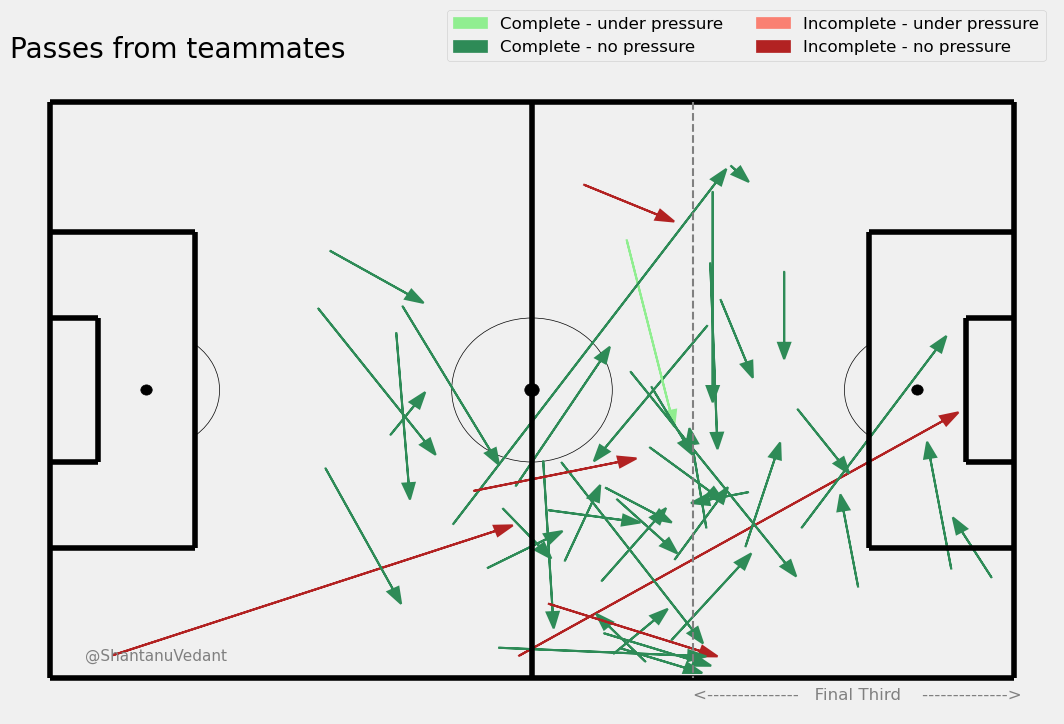

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['type.name'] == 'Pass') &
                           (df_messi['pass.recipient.name'] == messi_name) &
                           (~df_messi['pass.type.name'].isin(['Throw-in', 'Kick Off']))
                           ].iterrows():
    if row['pass.outcome.name'] == 'Incomplete':
        if row['under_pressure'] == True:
            color = "salmon"
        else:
            color = "firebrick"
    else:
        if row['under_pressure'] == True:
            color = 'lightgreen'
        else:
            color = 'seagreen'
            
    ax.arrow(row['location_x'],
             row['location_y'],
             row['end_location_x'] - row['location_x'],
             row['end_location_y'] - row['location_y'],
             color=color,
             linewidth=1.5,
             head_width=1.5,
             length_includes_head=True
             )
    
greenPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'lightgreen')
redPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'salmon')

greenPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'seagreen')
redPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'firebrick')

leg = ax.legend([greenPatch_up, greenPatch, redPatch_up, redPatch],
                ['Complete - under pressure', 'Complete - no pressure',
                 'Incomplete - under pressure', 'Incomplete - no pressure'],
                loc='upper right',
                bbox_to_anchor = (1, 1.1),
                fontsize=12,
                ncol=2)

plt.plot([80, 80], [0, 80],
         color='grey',
         linewidth=1.5,
         linestyle='--'
         )

plt.text(80, 83, "<---------------   Final Third    -------------->",
         {'color': 'grey', 'fontsize': 12})

ax.set_title(f"Passes from teammates",
            loc='left')

fig.savefig(f"{derby_folder}to_messi_passmap.png")

#### Passes Allowed Per Defensive Action (PPDA)

##### PPDA calculation

In [29]:
# Cutting the pitch
x_min_cut = range(0, 120, 20)
x_max_cut = range(20, 121, 20)

# Empty dataframe creation for result
ppda_df = pd.DataFrame(columns=['match_id','x_min', 'x_max', 'ppda_barca', 'ppda_opponent'])

# For all matches from 2009/2010, calculate PPDA
for match_id in tqdm(match_id_0910):
    ppda = []
    for x_min, x_max in zip(x_min_cut, x_max_cut):
        ppda_window = calculate_ppda(df_messi,
                                     match_id,
                                     x_min, x_max,
                                     0.0, 80.0)
        opponent = [list(ppda_window.keys()
                         )[0] if list(ppda_window.keys()
                                      )[0] != 'Barcelona' else list(ppda_window.keys()
                                                                    )[1]][0]
        ppda.append([match_id, x_min, x_max, ppda_window['Barcelona'], ppda_window[opponent]
                     ])

    temp_df = pd.DataFrame(data=ppda,
                           columns=['match_id','x_min', 'x_max', 'ppda_barca', 'ppda_opponent'])
    
    ppda_df = ppda_df.append(temp_df, ignore_index=True)

ppda_df.head()

  0%|          | 0/35 [00:00<?, ?it/s]

/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ppda_df = ppda_df.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ppda_df = ppda_df.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ppda_df = ppda_df.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ppda_df = ppda_df.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ppda_df = ppda_df.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ppda_df = ppda_df.append(temp_df, ignore_index=True)
/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/2965981158.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

,match_id,x_min,x_max,ppda_barca,ppda_opponent
0,69243,0,20,1.135135,0.824324
1,69243,20,40,0.685714,1.020619
2,69243,40,60,1.027397,2.696970
3,69243,60,80,1.047619,2.329412
4,69243,80,100,2.120000,2.224138


##### PPDA visualization for a particular match

PPDA of Barcelona during the derby, compared to average of the 2009/2010 season

/var/folders/zp/1c7tklxn4kjfh083fplkjgq80000gn/T/ipykernel_62647/3772183870.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mapper, shrink=0.7, label='Distance from average')


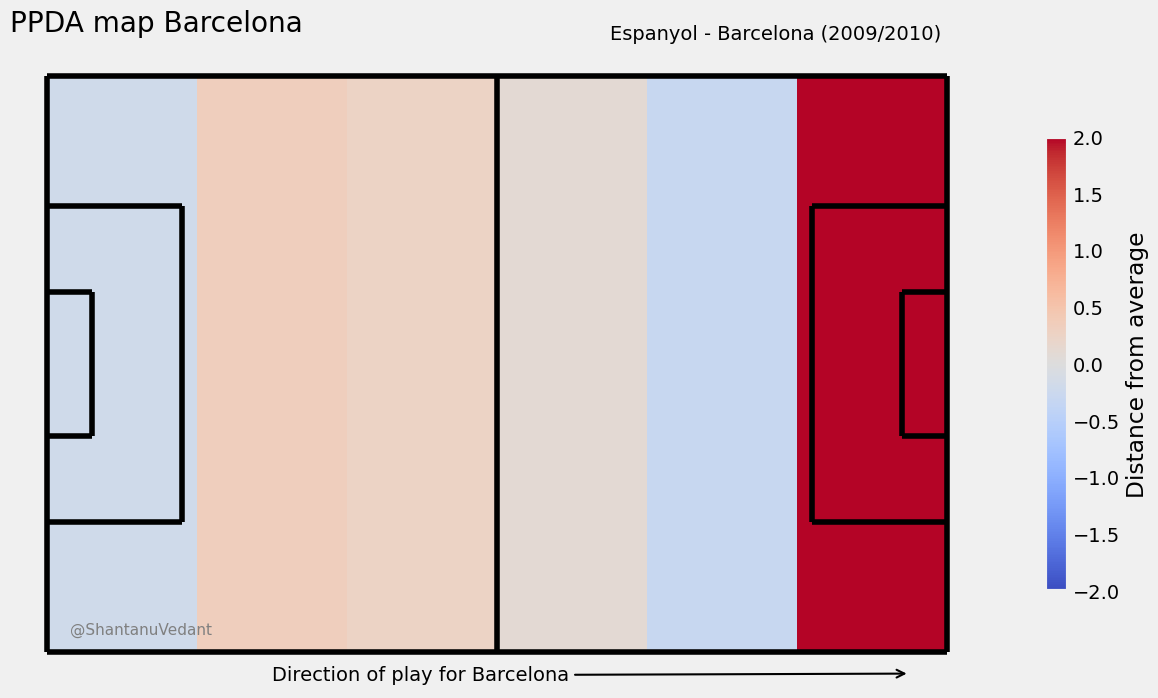

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
draw_pitch(ax)

minima = -2
maxima = 2

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap= 'coolwarm')

plt.colorbar(mapper, shrink=0.7, label='Distance from average')

for index, row in ppda_df[ppda_df['match_id'] == match_id_min_xg].iterrows():
    mean_ppda = ppda_df[(ppda_df['x_min'] == row['x_min']) &
                        (ppda_df['x_max'] == row['x_max'])
                        ]['ppda_barca'].mean()
    # Create a Rectangle patch
    rect = patches.Rectangle((row['x_min'], 0),
                             row['x_max'] - row['x_min'],
                             80,
                             linewidth=1,
                             edgecolor='none',
                             facecolor=mapper.to_rgba(row['ppda_barca']-mean_ppda),
                             label=row['ppda_barca'])

    # Add the patch to the Axes
    ax.add_patch(rect)
    
ax.set_title("PPDA map Barcelona",
            loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(75, -5))

ax.annotate("Direction of play for Barcelona",
            xy=(115, 83), xytext=(30, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'ppda_barcelona.png')